![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 13 - Attention and Transformers </center>
### <center> Attention </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/13_AttentionAndTransfomers/MainAttention.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/13_AttentionAndTransfomers/DeepLearningFramework ./DeepLearningFramework

In [4]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import torch
import torch.nn            as nn
import torch.optim         as optim
import torchtext

from torchtext.vocab import Vocab

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
DEVICE

device(type='cuda', index=0)

#### Load the data:

In [5]:
import re

def NormalizeEnglish(line):
    line = line.lower().strip()
    line = re.sub(r"([.!?])", r" \1",     line) #-- add space before [.!?]
    line = re.sub(r"[^a-zA-Z.!?]+", r" ", line) #-- keep only letters and [.!?]
    return line

def NormalizeHebrew(line):
    line = line.strip()
    line = re.sub(r"([.!?])", r" \1",            line)
    line = re.sub(r"[^\u0590-\u05fe.!?]+", r" ", line)
    return line

dirPath = '../../data/Translation//'
lLines  = []
with open(dirPath + 'heb.txt', encoding='utf-8') as oFile:
    for line in oFile:
        lSplit  = line.split('\t')[:2]
        lLines += [(NormalizeEnglish(lSplit[0]), NormalizeHebrew(lSplit[1]))]

lLines[26600:26605], len(lLines)

([('tom found evidence .', 'תום מצא ראיות .'),
  ('tom freed the bird .', 'טום שחרר את הציפור .'),
  ('tom freed the bird .', 'טום שלח את הציפור לחופשי .'),
  ('tom gasped for air .', 'תום נאבק לנשום .'),
  ('tom gets headaches .', 'תום מקבל כאבי ראש .')],
 126692)

#### Keep only short sentences:

In [6]:
mData = np.array(lLines, dtype=np.object_)
mData.shape

(126692, 2)

In [7]:
MAX_LENGTH  = 6
LineLength  = np.vectorize(lambda line: len(line.split()))
vLineLength = LineLength(mData[:,0])
mData       = mData[vLineLength<MAX_LENGTH,:]
N           = mData.shape[0]
N

38143

#### Build vocabularies:

In [8]:
from torchtext.vocab import build_vocab_from_iterator

def YieldTokens(lLines):
    for line in lLines:
        yield line.split()

def MakeVocab(lLines):
    oVocab = build_vocab_from_iterator(YieldTokens(lLines), min_freq=3, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
    oVocab.set_default_index(oVocab['<UNK>'])
    return oVocab

lEnglish  = mData[:,0]
lHebrew   = mData[:,1]
oEngVocab = MakeVocab(lEnglish)
oHebVocab = MakeVocab(lHebrew)

len(oEngVocab), len(oHebVocab)

(3628, 5320)

#### Line2Tensor:

In [9]:
def Line2Tensor(oVocab, line):
    lLine = ['<SOS>'] + line.split() + ['<EOS>']
    return torch.tensor(oVocab(lLine))

def Tensor2Line(oVocab, vLine):
    return ' '.join([oVocab.get_itos()[e] for e in vLine])
    
#-- Test:
eng1 = lEnglish[152]
heb1 = lHebrew [152]
eng2 = Line2Tensor(oEngVocab, eng1)
heb2 = Line2Tensor(oHebVocab, heb1)
eng3 = Tensor2Line(oEngVocab, eng2)
heb3 = Tensor2Line(oHebVocab, heb2)

print(f'Origianl (Eng) - {eng1}')
print(f'Origianl (Heb) - {heb1}')
print(f'Tensor   (Eng) - {eng2}')
print(f'Tensor   (Heb) - {heb2}')
print(f'Back     (Eng) - {eng3}')
print(f'Back     (Heb) - {heb3}')

Origianl (Eng) - hold it !
Origianl (Heb) - עצור !
Tensor   (Eng) - tensor([  1, 190,  10,  28,   2])
Tensor   (Heb) - tensor([  1, 456,  16,   2])
Back     (Eng) - <SOS> hold it ! <EOS>
Back     (Heb) - <SOS> עצור ! <EOS>


#### Dataset:

In [10]:
if False:
    class LangDataset(torch.utils.data.Dataset):
        def __init__(self, lSrc, lTrg, oSrcVocab, oTrgVocab):
            self.lSrc      = lSrc
            self.lTrg      = lTrg
            self.oSrcVocab = oSrcVocab
            self.oTrgVocab = oTrgVocab

        def __len__(self):
            return len(self.lSrc)

        def __getitem__(self, idx):
            sSrc = self.lSrc[idx]
            sTrg = self.lTrg[idx]

            vSrc = Line2Tensor(self.oSrcVocab, sSrc)
            vTrg = Line2Tensor(self.oTrgVocab, sTrg)

            return vSrc, vTrg       

In [11]:
from DeepLearningFramework.AttentionUtils import LangDataset

oDataset           = LangDataset(lEnglish, lHebrew, oEngVocab, oHebVocab)
vEngLine, vHebLine = oDataset[155]

Tensor2Line(oEngVocab, vEngLine), Tensor2Line(oHebVocab, vHebLine)

('<SOS> hug tom . <EOS>', '<SOS> <UNK> את תום . <EOS>')

In [12]:
from torch.utils.data import random_split

nTrain              = 34000
nTest               = N - nTrain
oTrainSet, oTestSet = random_split(oDataset, [nTrain, nTest])

len(oTrainSet), len(oTestSet)

(34000, 4143)

#### Data loader:

In [13]:
from torch.nn.utils.rnn import pad_sequence

oSrcVocab = oEngVocab
oTrgVocab = oHebVocab
if False:
    def LangCollate(lBatch):
        lSrc, lTrg = zip(*lBatch)
        mTrg       = pad_sequence(lTrg, padding_value=oTrgVocab['<PAD>'], batch_first=True)

        return (lSrc, mTrg)

In [14]:
from torch.utils.data                     import DataLoader
from DeepLearningFramework.AttentionUtils import LangCollate

batchSize = 128
oTrainDL  = DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, collate_fn=LangCollate, num_workers=2, persistent_workers=True)
oTestDL   = DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=LangCollate, num_workers=2, persistent_workers=True)

lSrc, mTrg = next(iter(oTrainDL))
len(lSrc), lSrc[0].shape, mTrg.shape

(128, torch.Size([6]), torch.Size([128, 8]))

#### Encoder RNN:
* The encoder can be bidirectional.
* The encoder can have more than one layer.
* We use `PackedSequence` for more efficient computation.
* **Input**:
    * `lSrc` a list of the input tensors where:
        * `len(lSrc) = N`
        * `lSrc[ii].shape = (T_i,)`
* **Output:**
    * `mH` with `mH.shape = (N, T, H)` - All intermediate states.<br>
    `mH` is a padded tensor.
    * `mS` with `mS.shape = (1, N, H)` - The last hidden state.
<img src="https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/13_AttentionAndTransfomers//Encoder.png?raw=true" alt="Encoder" style="width: 400px;"/>

In [15]:
from torch.nn.utils.rnn import pack_sequence, PackedSequence, pad_packed_sequence

def PackedAs(mData, mPack):
    return PackedSequence(mData, mPack.batch_sizes, mPack.sorted_indices, mPack.unsorted_indices)

class EncoderRNN(nn.Module):
    def __init__(self, V, D, H, p):
        super().__init__()
        self.oEmbedding = nn.Embedding(V, D, padding_idx=oEngVocab['<PAD>'])
        self.oGRU       = nn.GRU      (D, H)
        self.oDropout   = nn.Dropout  (p)
        
    def forward(self, lSrc):
        DEVICE     = next(iter(self.parameters())).device
        mPackSrc   = pack_sequence  (lSrc, enforce_sorted=False).to(DEVICE) #-- mPackSrc.shape = (N*T,)
        mE         = self.oEmbedding(mPackSrc.data)                         #-- mE      .shape = (N*T, D)
        mE         = self.oDropout  (mE)
        mPackE     = PackedAs       (mE, mPackSrc) #-- mPackE  .shape = (N*T, D)
        mPackH, mS = self.oGRU      (mPackE)       #-- mPackH  .shape = (N*T, H)

        mH, _      = pad_packed_sequence(mPackH, batch_first=True, padding_value=oSrcVocab['<PAD>']) #-- mH.shape = (N, T, H)

        return mH, mS
#===========================================================================#
#===========================================================================#

V      = len(oSrcVocab)
D      = 64
H      = 32
p      = .2
mH, mS = EncoderRNN(V, D, H, p)(lSrc)
mH.shape, mS.shape

(torch.Size([128, 7, 32]), torch.Size([1, 128, 32]))

#### Attention
* The NN is a simple fully connected NN (with one hidden layer).
* The NN block can be replaced by other mechanisms.
* **Input:**
    * `mH` with `mH.shape = (N, T, H)` - The encoder output 
    * `mS` with `mS.shape = (1, N, H)` - The decoder last hidden state 
* **Output:**
    * `mC` with `mC.shape = (N, H)` - The context vector(s)<br>
    `mC` is a linear combination of the hidden states `mH`.
    * `mW` with `mW.shape = (N, T)` - The attention vector(s)<br>
    (this is only for later visualizations)
* To ignore `<PAD>` values we add a mask operation before the `softmax`.<br>
That is, a padded hidden state, will be multiplied by a $0$ weight.
<img src="https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/13_AttentionAndTransfomers//Attention.png?raw=true" alt="Attention" style="width: 400px;"/>

In [16]:
class Attention(nn.Module):
    def __init__(self, H):
        super().__init__()
        self.oNN  = nn.Sequential(
            nn.Linear (2*H, H), nn.ReLU(),
            nn.Linear (H,   1),
            nn.Flatten(start_dim=-2)
        )
       
    def forward(self, mH, mS):
        #-- mH.shape = (N, T, H)
        #-- mS.shape = (1, N, H)
        T     = mH.shape[1]
        
        #-- Apply NN:
        mS    = mS[0][:,None,:].repeat(1, T, 1)         #-- mS   .shape = (N, T, H)
        mSH   = torch.cat([mS, mH], dim=2)              #-- mSH  .shape = (N, T, 2*H)
        mAttn = self.oNN(mSH)                           #-- mAttn.shape = (N, T)
        
        #-- Apply mask & soft,ax:
        mMask = mH[:,:,0] == oSrcVocab['<PAD>']         #-- mMask.shape = (N, T)
        mAttn = mAttn.masked_fill(mMask, -float('Inf')) #-- mAttn.shape = (N, T)
        mW    = torch.softmax(mAttn, dim=1)             #-- mW   .shape = (N, T)
        
        #-- Compute output:
        mC    = (mW[:,None,:] @ mH).squeeze(1)          #-- mC   .shape = (N, H)
        
        return mC, mW

#### Decoder RNN:
The `forward` method applies a <u>single</u> decoding iteration.
* **Input:**
    * `vTrg` with `vTrg.shape = (N,)` - The input tensor
    * `mH` with `mH.shape = (N, T, H)` - The encoder output 
    * `mS` with `mS.shape = (1, N, H)` - The decoder last hidden state 
* **Output:**
    * `mZ` with `mZ.shape = (N, V)` - The prediction logits.
    * `mS` with `mS.shape = (1, N, H)` - The decoder hidden state 
    * `mW` with `mW.shape = (N, T)` - The attention vector(s)<br>
    (this is only for later visualizations)
    
* The prediction of `mZ` is done using `mS`<br>
(and optionally, also with the context `mC` and the input embedding `mE`)
* In the first iteration, `mS` is the last hidden state of the decoder.

<img src="https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/13_AttentionAndTransfomers//Decoder.png?raw=true" alt="Decoder" style="width: 400px;"/>

In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, V, D, H, p):
        super().__init__()
        self.oAttn      = Attention   (H)
        self.oEmbedding = nn.Embedding(V, D)
        self.oGRU       = nn.GRU      (D + 1*H, H)
        self.oLinear    = nn.Linear   (D + 2*H, V)
        self.oDropout   = nn.Dropout  (p)
        
    def forward(self, vTrg, mH, mS):
        mC, mW = self .oAttn     (mH, mS)               #-- mC    .shape = (N, H)
        mE     = self .oEmbedding(vTrg)                 #-- mE    .shape = (N, D)
        mE     = self .oDropout  (mE)                   #-- mE    .shape = (N, D)
        mEC    = torch.cat       ([mE, mC], dim=1)      #-- mEC   .shape = (N, D+H)
        _, mS  = self .oGRU      (mEC[None,:,:], mS)    #-- mS    .shape = (1, N, H)
        
        mECS   = torch.cat      ([mEC, mS[-1]], dim=1) #-- mECS.shape = (N, D+2*H)
        mZ     = self .oLinear  (mECS)                 #-- mZ  .shape = (N, V)
        
        return mZ, mS, mW

In [18]:
V          = len(oTrgVocab)
vTrg       = mTrg[:,0]
mZ, mS, mW = DecoderRNN(V, D, H, .2)(vTrg, mH, mS)

mZ.shape, mS.shape, mW.shape

(torch.Size([128, 5320]), torch.Size([1, 128, 32]), torch.Size([128, 7]))

#### Seq2Seq (full model):
* **Input:**
    * `lSrc` a list of the input tensors where:
        * `len(lSrc) = N`
        * `lSrc[ii].shape = (T_i,)`
    * `mTrg` with `mTrg.shape = (N, T)` - The correct target
    * `pTeacher` - the probability for teacher forcing
* **Output:**
    * `mLogits` with `mLogits.shape = (N, T, V)` - The prediction logits.
    
<img src="https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/13_AttentionAndTransfomers//Seq2SeqWithAttention.png?raw=true" alt="Seq2Seq" style="width: 600px;"/>

In [19]:
Vsrc = len(oSrcVocab)
Vtrg = len(oTrgVocab)

class Seq2Seq(nn.Module):
    def __init__(self):
        super().__init__()
        D               = 256  #-- D = Embedding
        H               = 256  #-- H = Hidden state
        p               = .5
        
        self.oEncoder   = EncoderRNN(Vsrc, D, H, p)
        self.oDecoder   = DecoderRNN(Vtrg, D, H, p)

    def forward(self, lSrc, mTrg, pTeacher=0.5):
        DEVICE   = next(iter(self.parameters())).device
        N, T     = mTrg.shape                                 #-- mTrg      .shape = (N, T)
        mLogits  = torch.zeros((N, Vtrg, T-1), device=DEVICE) #-- mLogitsOut.shape = (N, V, T)
        bTeacher = torch.rand(1) < pTeacher
        
        #-- Encode:
        mH, mS  = self.oEncoder(lSrc) #-- mH        .shape = (N, T, H)

        #-- Decode:
        vTrgIn = mTrg[:,0]            #-- vTrgIn    .shape = (N,)     
        for ii in range(T - 1):
            mZ, mS, _       = self.oDecoder(vTrgIn, mH, mS)
            mLogits[:,:,ii] = mZ
           
            if bTeacher == True:
                vTrgIn = mTrg[:,ii+1] #-- vTrgIn.shape(N)
            else:
                vTrgIn = mZ.argmax(dim=1)
                            
        return mLogits
#===========================================================================#
#===========================================================================#
mLogits = Seq2Seq()(lSrc, mTrg, 0.5)
mLogits.shape

torch.Size([128, 5320, 7])

In [20]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (lSrc, mTrg) in enumerate(oDataDL):
        mTrg = mTrg.to(DEVICE)
     
        
        if bTrain == True:
            #-- Forward:
            mOut = oModel(lSrc, mTrg, pTeacher=0.5)
            loss = Loss  (mOut, mTrg[:,1:]) #-- omit <SOS>
            
            #-- Backward:
            vLR[ii] = oScheduler.get_last_lr()[0]
            oOptim    .zero_grad() #-- set gradients to zeros
            loss      .backward () #-- backward
            oOptim    .step     () #-- update parameters
            oScheduler.step     () #-- update learning rate

        else:
            with torch.no_grad():
                #-- Forward:
                mOut = oModel(lSrc, mTrg, pTeacher=0)
                loss = Loss  (mOut, mTrg[:,1:]) #-- omit <SOS>

        with torch.no_grad():
            Nb           = mTrg.shape[0]
            count       += Nb
            epochLoss   += Nb * loss.item()
            epochMetric += Nb * Metric(mOut, mTrg[:,1:])
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [21]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel
from DeepLearningFramework.Metric   import Accuracy

DEVICE = torch.device       ('cuda:0' if torch.cuda.is_available() else 'cpu') 
Loss   = nn.CrossEntropyLoss(ignore_index=oTrgVocab['<PAD>'])
Metric = Accuracy           (ignoreIndex =oTrgVocab['<PAD>'])

In [39]:
nEpochs    = 25
nIter      = nEpochs * len(oTrainDL)

oModel     = Seq2Seq    ().to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=1e-1)
oScheduler = OneCycleLR (oOptim, max_lr=5e-3, total_steps=nIter)
lHistory   = TrainModel (oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, Epoch=Epoch, sModelName='Seq2SeqWithAttention')

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  4.620 | Val loss:  3.807 | Train Metric:  0.340 | Val Metric:  0.406 | epoch time:  5.855 | <-- Checkpoint!
Epoch 001: | Train loss:  3.304 | Val loss:  3.086 | Train Metric:  0.497 | Val Metric:  0.495 | epoch time:  5.637 | <-- Checkpoint!
Epoch 002: | Train loss:  2.605 | Val loss:  2.488 | Train Metric:  0.560 | Val Metric:  0.549 | epoch time:  5.549 | <-- Checkpoint!
Epoch 003: | Train loss:  2.110 | Val loss:  2.309 | Train Metric:  0.595 | Val Metric:  0.577 | epoch time:  5.509 | <-- Checkpoint!
Epoch 004: | Train loss:  1.796 | Val loss:  2.175 | Train Metric:  0.628 | Val Metric:  0.575 | epoch time:  5.492 |
Epoch 005: | Train loss:  1.639 | Val loss:  2.189 | Train Metric:  0.646 | Val Metric:  0.576 | epoch time:  5.538 |
Epoch 006: | Train loss:  1.567 | Val loss:  2.177 | Train Metric:  0.654 | Val Metric:  0.589 | epoch time

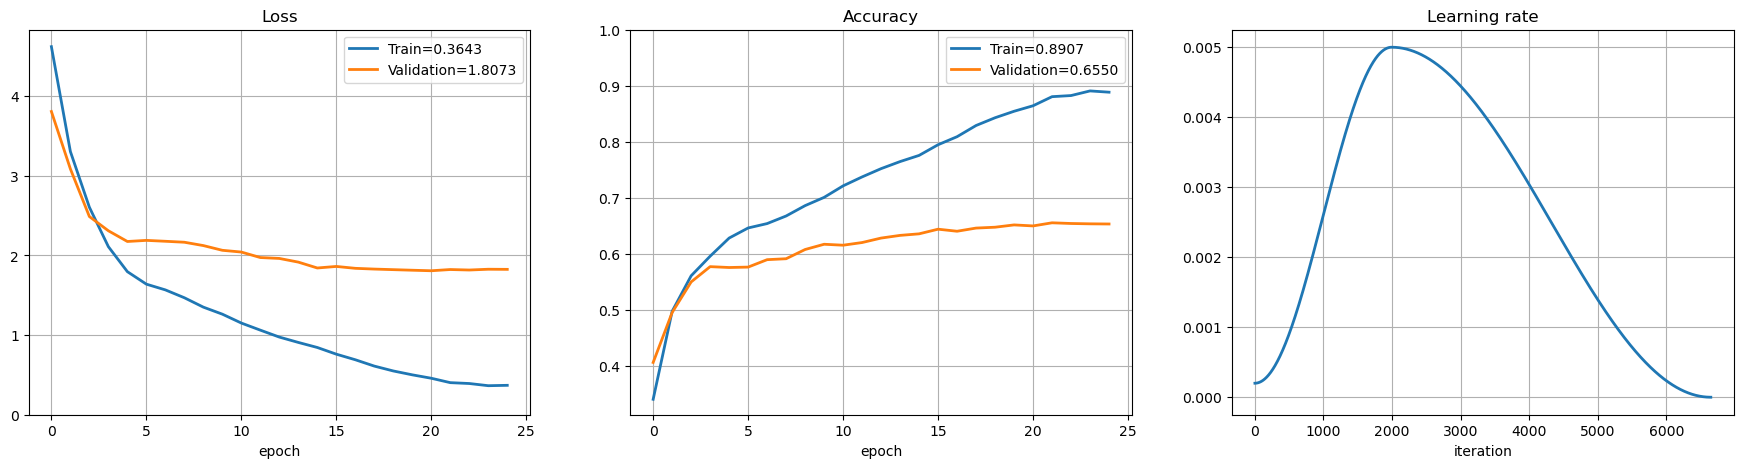

In [40]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

In [25]:
# oModel = Seq2Seq      ()
# oModel.load_state_dict(torch.load('Seq2SeqWithAttention_v1.pt'))
# oModel.to             (DEVICE)
# oModel.train          (False)

### Exercise (predict implementation)
Complete the `Predict` function implementation.  

Note: A [beam search](https://en.wikipedia.org/wiki/Beam_search) should be used instead of top 1 method.

In [100]:
from torch.distributions.categorical import Categorical

def Predict(oModel, vSrc, bTop1=False):
    #-- vSrc.shape = (T,)
    MAX_LENGTH = 16
    DEVICE     = next(oModel.parameters()).device
    trgIn      = torch.tensor([oTrgVocab['<SOS>']], dtype=torch.int32, device=DEVICE)
    vTrgOut    = torch.empty(MAX_LENGTH, device=DEVICE)
    Tsrc       = vSrc.shape[0]
    mW         = torch.zeros((Tsrc, MAX_LENGTH))
    
    #-- Encode:
    mH, mS  = ???
    
    #-- Decode:
    for ii in range(MAX_LENGTH):
        mZ, mS, mW[:,ii] = ???

        if bTop1 == True:
            ???
        else:
            ???

        vTrgOut[ii] = ???
        
        if ??? == oTrgVocab['<EOS>']:
            break

    return vTrgOut[:ii+1], mW[:,:ii+1]

vTrgOut, mW = Predict(oModel, lSrc[0])
vTrgOut.shape, mW.shape

(torch.Size([5]), torch.Size([6, 5]))

In [41]:
lSpecial = ['<UNK>', '<EOS>']

def ShowAttention(sEng, sHeb, mW):
    lEng = sEng.split()
    lHeb = sHeb.split()
    
    fig, ax = plt.subplots(figsize=(5, 5))
    cax     = ax.matshow(mW, cmap='bone', vmin=0)
    lHeb    = [word if word  in lSpecial else word[::-1] for word in lHeb]
    
    plt.xticks(ticks=range(len(lHeb)), labels=lHeb)
    plt.yticks(ticks=range(len(lEng)), labels=lEng)

    plt.grid(color=[0.5,0.5,0.5], linestyle=':', axis='y')
    plt.show()
    
    return fig

,English,GT (Hebrew),Generated
0,yes i know .,כן אני יודעת .,כן אני יודע . <EOS>


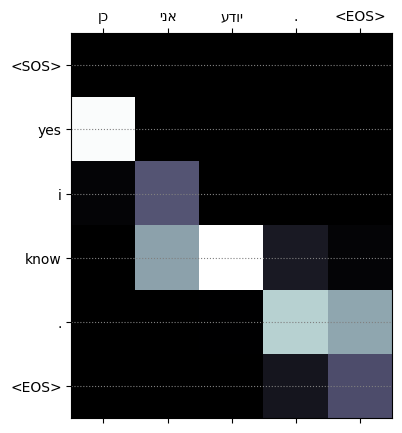

In [52]:
dLang = pd.DataFrame(index=range(1), columns=['English', 'GT (Hebrew)', 'Generated'])

for ii in range(1):
    idx        = np.random.randint(nTest)
    vEng, vHeb = oTestSet[idx]
    with torch.no_grad():
        vHebOut, mW = Predict(oModel, vEng, bTop1=False)
        vHebOut     = vHebOut.int()

    sEng             = Tensor2Line(oEngVocab, vEng[1:-1])
    sHeb             = Tensor2Line(oHebVocab, vHeb[1:-1])
    sHebHat          = Tensor2Line(oHebVocab, vHebOut)
    dLang.iloc[ii,:] = [sEng, sHeb, sHebHat]

display(dLang)

sEng = Tensor2Line(oEngVocab, vEng)
ShowAttention(sEng, sHebHat, mW);

In [ ]:
# from torch.distributions.categorical import Categorical

# def Predict(oModel, vSrc, bTop1=False):
#     #-- vSrc.shape = (T,)
#     MAX_LENGTH = 16
#     DEVICE     = next(oModel.parameters()).device
#     trgIn      = torch.tensor([oTrgVocab['<SOS>']], dtype=torch.int32, device=DEVICE)
#     vTrgOut    = torch.empty(MAX_LENGTH, device=DEVICE)
#     Tsrc       = vSrc.shape[0]
#     mW         = torch.zeros((Tsrc, MAX_LENGTH))
    
#     #-- Encode:
#     mH, mS  = oModel.oEncoder([vSrc])
    
#     #-- Decode:
#     for ii in range(MAX_LENGTH):
#         mZ, mS, mW[:,ii] = oModel.oDecoder(trgIn, mH, mS)

#         if bTop1 == True:
#             trgIn = mZ.argmax(dim=1)
#         else:
#             trgIn = Categorical(logits=mZ).sample()

#         vTrgOut[ii] = trgIn
        
#         if trgIn == oTrgVocab['<EOS>']:
#             break

#     return vTrgOut[:ii+1], mW[:,:ii+1]

# vTrgOut, mW = Predict(oModel, lSrc[0])
# vTrgOut.shape, mW.shape